## Uczenie maszynowe UMZ 2019/2020
### 24 marca 2020
# 3. Regresja logistyczna

Wbrew nazwie, *regresja* logistyczna jest algorytmem służącym do rozwiązywania problemów *klasyfikacji* (wcale nie problemów *regresji*!)

## 3.1. Dwuklasowa regresja logistyczna

Zacznijmy od najprostszego przypadku: chcemy nasze dane przypisać do jednej z **dwóch** klas.
W tym celu użyjemy regresji logistycznej **dwuklasowej**.

<img style="float: right;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/450px-Kosaciec_szczecinkowaty_Iris_setosa.jpg">

### Przykład: kosaciec szczecinkowy (_Iris setosa_)

Mamy dane dotyczące długości płatków i chcielibyśmy na tej podstawie określić, czy jest to roślina z gatunku _Iris setosa_

In [67]:
# Przydatne importy

import numpy as np
import matplotlib
import matplotlib.pyplot as pl
import ipywidgets as widgets

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.display import display, Math, Latex

# Przydatne funkcje

# Wyświetlanie macierzy w LaTeX-u
def LatexMatrix(matrix):
    ltx = r'\left[\begin{array}'
    m, n = matrix.shape
    ltx += '{' + ("r" * n) + '}'
    for i in range(m):
        ltx += r" & ".join([('%.4f' % j.item()) for j in matrix[i]]) + r" \\ "
    ltx += r'\end{array}\right]'
    return ltx

# Hipoteza (wersja macierzowa)
def hMx(theta, X):
    return X * theta

# Wykres danych (wersja macierzowa)
def regdotsMx(X, y, xlabel, ylabel):    
    fig = pl.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter([X[:, 1]], [y], c='r', s=50, label='Dane')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.margins(.05, .05)
    pl.ylim(y.min() - 1, y.max() + 1)
    pl.xlim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)
    return fig

# Wykres krzywej regresji (wersja macierzowa)
def reglineMx(fig, fun, theta, X):
    ax = fig.axes[0]
    x0 = np.min(X[:, 1]) - 1.0
    x1 = np.max(X[:, 1]) + 1.0
    L = [x0, x1]
    LX = np.matrix([1, x0, 1, x1]).reshape(2, 2)
    ax.plot(L, fun(theta, LX), linewidth='2',
            label=(r'$y={theta0:.2}{op}{theta1:.2}x$'.format(
                theta0=float(theta[0][0]),
                theta1=(float(theta[1][0]) if theta[1][0] >= 0 else float(-theta[1][0])),
                op='+' if theta[1][0] >= 0 else '-')))

# Legenda wykresu
def legend(fig):
    ax = fig.axes[0]
    handles, labels = ax.get_legend_handles_labels()
    # try-except block is a fix for a bug in Poly3DCollection
    try:
        fig.legend(handles, labels, fontsize='15', loc='lower right')
    except AttributeError:
        pass

# Wersja macierzowa funkcji kosztu
def JMx(theta,X,y):
    m = len(y)
    J = 1.0 / (2.0 * m) * ((X * theta - y).T * ( X * theta - y))
    return J.item()

# Wersja macierzowa gradientu funkcji kosztu
def dJMx(theta,X,y):
    return 1.0 / len(y) * (X.T * (X * theta - y)) 

# Implementacja algorytmu gradientu prostego za pomocą numpy i macierzy
def GDMx(fJ, fdJ, theta, X, y, alpha=0.1, eps=10**-3):
    current_cost = fJ(theta, X, y)
    logs = [[current_cost, theta]]
    while True:
        theta = theta - alpha * fdJ(theta, X, y) # implementacja wzoru
        current_cost, prev_cost = fJ(theta, X, y), current_cost
        if current_cost > 10000:
            break
        if abs(prev_cost - current_cost) <= eps:
            break
        logs.append([current_cost, theta]) 
    return theta, logs

thetaStartMx = np.matrix([0, 0]).reshape(2, 1)

# Funkcja, która rysuje próg
def threshold(fig, theta):
    x_thr = (0.5 - theta.item(0)) / theta.item(1)
    ax = fig.axes[0]
    ax.plot([x_thr, x_thr], [-1, 2],
            color='orange', linestyle='dashed',
            label=u'próg: $x={:.2F}$'.format(x_thr))

In [68]:
# Wczytanie danych

data_iris = pandas.read_csv('iris.csv')
print(data_iris[:6])

    sl   sw   pl   pw          Gatunek
0  5.2  3.4  1.4  0.2      Iris-setosa
1  5.1  3.7  1.5  0.4      Iris-setosa
2  6.7  3.1  5.6  2.4   Iris-virginica
3  6.5  3.2  5.1  2.0   Iris-virginica
4  4.9  2.5  4.5  1.7   Iris-virginica
5  6.0  2.7  5.1  1.6  Iris-versicolor


In [69]:
data_iris_setosa = pandas.DataFrame()
data_iris_setosa['dł. płatka'] = data_iris['pl']  # "pl" oznacza "petal length"
data_iris_setosa['Iris setosa?'] = data_iris['Gatunek'].apply(lambda x: 1 if x=='Iris-setosa' else 0)
print(data_iris_setosa[:6])

   dł. płatka  Iris setosa?
0         1.4             1
1         1.5             1
2         5.6             0
3         5.1             0
4         4.5             0
5         5.1             0


Czy możemy tu zastosować regresję liniową?

Spróbujmy:

In [70]:
print(data_iris_setosa.values.shape)

(150, 2)


In [71]:
import numpy as np

m, n_plus_1 = data_iris_setosa.values.shape
n = n_plus_1 - 1
Xn = data_iris_setosa.values[:, 0:n].reshape(m, n)

XMx3 = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
yMx3 = np.matrix(data_iris_setosa.values[:, 1]).reshape(m, 1)

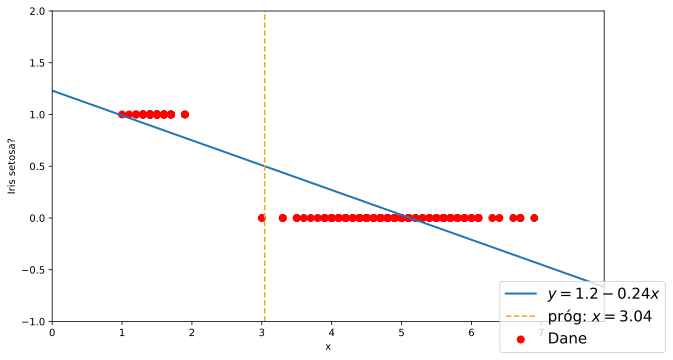

In [72]:
fig = regdotsMx(XMx3, yMx3, 'x', 'Iris setosa?')
theta_e3, logs3 = GDMx(JMx, dJMx, thetaStartMx, XMx3, yMx3, alpha=0.03, eps=0.000001)
reglineMx(fig, hMx, theta_e3, XMx3)
threshold(fig, theta_e3)
legend(fig)

 * Krzywa regresji liniowej jest niezbyt dopasowana do danych klasyfikacyjnych.
 * Zastosowanie progu $y = 0.5$ nie zawsze pomaga uzyskać sensowny rezultat.
 * $h(x)$ może przyjmować wartości mniejsze od $0$ i większe od $1$ – jak interpretować takie wyniki?

Wniosek: w przypadku problemów klasyfikacyjnych regresja liniowa nie wydaje się najlepszym rozwiązaniem.

Zdefiniujmy sobie następującą funkcję, którą będziemy nazywać funkcją *logistyczną* (albo *sigmoidalną*):

**Funkcja logistyczna (sigmoidalna)**:

$$g(x) = \dfrac{1}{1+e^{-x}}$$

In [107]:
# Funkjca logistycza

def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

In [74]:
import matplotlib.pyplot as plt
def plot_logistic():
    x = np.linspace(-5,5,200)
    y = logistic(x)

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    plt.ylim(-.1,1.1)
    ax.plot(x, y, linewidth='2')

Wykres funkcji logistycznej $g(x) = \dfrac{1}{1+e^{-x}}$:

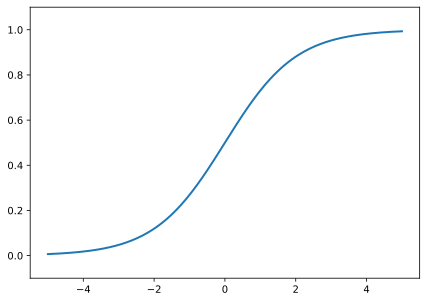

In [76]:
plot_logistic()

Funkcja logistyczna przekształca zbiór liczb rzeczywistych $\mathbb{R}$ w przedział otwarty $(0, 1)$.

Funkcja regresji logistycznej:

$$h_\theta(x) = g(\theta^T \, x) = \dfrac{1}{1 + e^{-\theta^T x}}$$

Wersja macierzowa:

$$h_\theta(X) = g(X \, \theta) = \dfrac{1}{1 + e^{-X \theta}}$$

In [77]:
# Funkcja regresji logistcznej
def h(theta, X):
    return 1.0/(1.0 + np.exp(-X * theta))

Funkcja kosztu dla regresji logistycznej:

$$J(\theta) = -\dfrac{1}{m} \left( \sum_{i=1}^{m} y^{(i)} \log h_\theta( x^{(i)} ) + \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta (x^{(i)}) \right) \right)$$

Gradient dla regresji logistycznej (wersja macierzowa):

$$\nabla J(\theta) = \frac{1}{|\vec y|} X^T \left( h_\theta(X) - \vec y \right)$$

(Jedyna różnica między gradientem dla regresji logistycznej a gradientem dla regresji liniowej to postać $h_\theta$).

In [78]:
# Funkcja kosztu dla regresji logistycznej
def J(h, theta, X, y):
    m = len(y)
    h_val = h(theta, X)
    s1 = np.multiply(y, np.log(h_val))
    s2 = np.multiply((1 - y), np.log(1 - h_val))
    return -np.sum(s1 + s2, axis=0) / m

In [79]:
# Gradient dla regresji logistycznej
def dJ(h, theta, X, y):
    return 1.0 / len(y) * (X.T * (h(theta, X) - y))

In [80]:
# Metoda gradientu prostego dla regresji logistycznej
def GD(h, fJ, fdJ, theta, X, y, alpha=0.01, eps=10**-3, maxSteps=10000):
    errorCurr = fJ(h, theta, X, y)
    errors = [[errorCurr, theta]]
    while True:
        # oblicz nowe theta
        theta = theta - alpha * fdJ(h, theta, X, y)
        # raportuj poziom błędu
        errorCurr, errorPrev = fJ(h, theta, X, y), errorCurr
        # kryteria stopu
        if abs(errorPrev - errorCurr) <= eps:
            break
        if len(errors) > maxSteps:
            break
        errors.append([errorCurr, theta]) 
    return theta, errors

In [81]:
# Uruchomienie metody gradientu prostego dla regresji logistycznej
thetaBest, errors = GD(h, J, dJ, thetaStartMx, XMx3, yMx3, 
                       alpha=0.1, eps=10**-7, maxSteps=1000)
print("error =", errors[-1][0])
print("theta =", thetaBest)

error = [[0.05755617]]
theta = [[ 5.02530461]
 [-1.99174803]]


In [82]:
# Funkcja regresji logistycznej (wersja skalarna)
def scalar_logistic_regression_function(theta, x):
    return 1.0/(1.0 + np.exp(-(theta.item(0) + theta.item(1) * x)))

# Rysowanie progu
def threshold_val(fig, x_thr):
    ax = fig.axes[0]
    ax.plot([x_thr, x_thr], [-1, 2],
            color='orange', linestyle='dashed',
            label=u'próg: $x={:.2F}$'.format(x_thr))

# Wykres krzywej regresji logistycznej
def logistic_regline(fig, theta, X):
    ax = fig.axes[0]
    x0 = np.min(X[:, 1]) - 1.0
    x1 = np.max(X[:, 1]) + 1.0
    Arg = np.arange(x0, x1, 0.1)
    Val = scalar_logistic_regression_function(theta, Arg)
    ax.plot(Arg, Val, linewidth='2')

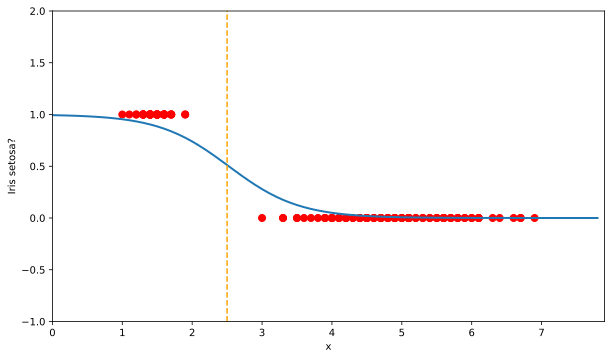

In [83]:
fig = regdotsMx(XMx3, yMx3, xlabel='x', ylabel='Iris setosa?')
logistic_regline(fig, thetaBest, XMx3)
threshold_val(fig, 2.5)

Traktujemy wartość $h_\theta(x)$ jako prawdopodobieństwo, że cecha przyjmie wartość pozytywną:

$$ h_\theta(x) = P(y = 1 \, | \, x; \theta) $$

Jeżeli $h_\theta(x) > 0.5$, to dla takiego $x$ będziemy przewidywać wartość $y = 1$.
W przeciwnym wypadku uprzewidzimy $y = 0$.

### Dwuklasowa regresja logistyczna: więcej cech

Jak postąpić, jeżeli będziemy mieli więcej niż jedną cechę $x$?

Weźmy pod uwagę następujące cechy:
 * długość działek kielicha
 * szerokość działek kielicha
 * długość płatka
 * szerokość płatka

In [88]:
data_iris_setosa_multi = pandas.DataFrame()
data_iris_setosa_multi['dł. płatków'] = data_iris['pl']  # "pl" oznacza "petal length" (długość płatków)
data_iris_setosa_multi['szer. płatków'] = data_iris['pw']  # "pw" oznacza "petal width" (szerokość płatków)
data_iris_setosa_multi['dł. dz. k.'] = data_iris['sl']  # "sl" oznacza "sepal length" (długość działek kielicha)
data_iris_setosa_multi['szer. dz. k.'] = data_iris['sw']  # "sw" oznacza "sepal width" (szerokość działek kielicha)
data_iris_setosa_multi['Iris setosa?'] = data_iris['Gatunek'].apply(lambda x: 1 if x=='Iris-setosa' else 0)
print(data_iris_setosa_multi[:6])

   dł. płatków  szer. płatków  dł. dz. k.  szer. dz. k.  Iris setosa?
0          1.4            0.2         5.2           3.4             1
1          1.5            0.4         5.1           3.7             1
2          5.6            2.4         6.7           3.1             0
3          5.1            2.0         6.5           3.2             0
4          4.5            1.7         4.9           2.5             0
5          5.1            1.6         6.0           2.7             0


In [89]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

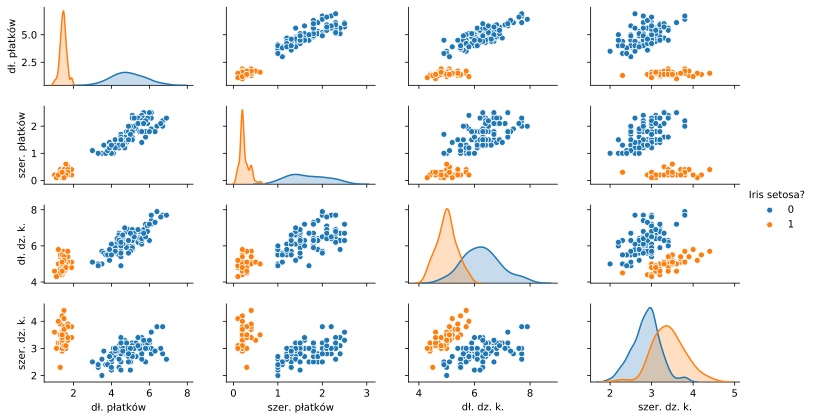

In [108]:
# Poniższy wykres przedstawia zależności między wszystkimi cechami

seaborn.pairplot(
    data_iris_setosa_multi,
    vars=[c for c in data_iris_setosa_multi.columns if c != 'Iris setosa?'], 
    hue='Iris setosa?', height=1.5, aspect=1.75)

In [91]:
# Przygotowanie danych
m, n_plus_1 = data_iris_setosa_multi.values.shape
n = n_plus_1 - 1
Xn = data_iris_setosa_multi.values[:, 0:n].reshape(m, n)

XMx4 = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
yMx4 = np.matrix(data_iris_setosa_multi.values[:, n]).reshape(m, 1)

print(XMx4[:6])
print(yMx4[:6])

[[1.  1.4 0.2 5.2 3.4]
 [1.  1.5 0.4 5.1 3.7]
 [1.  5.6 2.4 6.7 3.1]
 [1.  5.1 2.  6.5 3.2]
 [1.  4.5 1.7 4.9 2.5]
 [1.  5.1 1.6 6.  2.7]]
[[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [92]:
# Podział danych na zbiór trenujący i testowy
XTrain, XTest = XMx4[:100], XMx4[100:]
yTrain, yTest = yMx4[:100], yMx4[100:]

# Macierz parametrów początkowych
thetaTemp = np.ones(5).reshape(5,1)

In [93]:
thetaBest, errors = GD(h, J, dJ, thetaTemp, XTrain, yTrain, 
                       alpha=0.1, eps=10**-7, maxSteps=1000)
print("error =", errors[-1][0])
print("theta =", thetaBest)

error = [[0.006797]]
theta = [[ 1.11414027]
 [-2.89324615]
 [-0.66543637]
 [ 0.14887292]
 [ 2.13284493]]


### Funkcja decyzyjna regresji logistycznej

Funkcja decyzyjna mówi o tym, kiedy nasz algorytm będzie przewidywał $y = 1$, a kiedy $y = 0$

$$ c = \left\{ 
\begin{array}{ll}
1, & \mbox{gdy } P(y=1 \, | \, x; \theta) > 0.5 \\
0 & \mbox{w przeciwnym przypadku}
\end{array}\right.
$$

$$ P(y=1 \,| \, x; \theta) = h_\theta(x) $$

In [94]:
def classifyBi(theta, X):
    prob = h(theta, X).item()
    return (1, prob) if prob > 0.5 else (0, prob)

print("theta =", thetaBest)
print("x0 =", XTest[0])
print("h(x0) =", h(thetaBest, XTest[0]).item())
print("c(x0) =", classifyBi(thetaBest, XTest[0]), "\n")

theta = [[ 1.11414027]
 [-2.89324615]
 [-0.66543637]
 [ 0.14887292]
 [ 2.13284493]]
x0 = [[1.  6.3 1.8 7.3 2.9]]
h(x0) = 1.6061436959824898e-05
c(x0) = (0, 1.6061436959824898e-05) 



### Skuteczność

In [95]:
acc = 0.0
for i, rest in enumerate(yTest):
    cls, prob = classifyBi(thetaBest, XTest[i])
    if i < 10:
        print(int(yTest[i].item()), "<=>", cls, "-- prob:", round(prob, 4))
    acc += cls == yTest[i].item()

print("\nAccuracy:", acc / len(XTest))

0 <=> 0 -- prob: 0.0
1 <=> 1 -- prob: 0.9816
0 <=> 0 -- prob: 0.0001
0 <=> 0 -- prob: 0.0005
0 <=> 0 -- prob: 0.0001
1 <=> 1 -- prob: 0.9936
0 <=> 0 -- prob: 0.0059
0 <=> 0 -- prob: 0.0992
0 <=> 0 -- prob: 0.0001
0 <=> 0 -- prob: 0.0001

Accuracy: 1.0


## 3.4. Wieloklasowa regresja logistyczna

### Przykład: gatunki irysów (kosaćców)

<img style="float: right;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/450px-Kosaciec_szczecinkowaty_Iris_setosa.jpg">

Kosaciec szczecinkowy (_Iris setosa_)

<img style="float: right;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/736px-Iris_virginica.jpg">

Kosaciec amerykański (_Iris virginica_)

<img style="float: right;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/Blue_Flag%2C_Ottawa.jpg/600px-Blue_Flag%2C_Ottawa.jpg">

Kosaciec różnobarwny (_Iris versicolor_)

Cechy:
 * długość działek kielicha
 * szerokość działek kielicha
 * długość płatka
 * szerokość płatka

Wczytanie danych

In [96]:
import pandas
data_iris = pandas.read_csv('iris.csv')
data_iris[:6]

,sl,sw,pl,pw,Gatunek
0,5.2,3.4,1.4,0.2,Iris-setosa
1,5.1,3.7,1.5,0.4,Iris-setosa
2,6.7,3.1,5.6,2.4,Iris-virginica
3,6.5,3.2,5.1,2.0,Iris-virginica
4,4.9,2.5,4.5,1.7,Iris-virginica
5,6.0,2.7,5.1,1.6,Iris-versicolor


Przygotowanie danych

In [97]:
import numpy as np

features = ['sl', 'sw', 'pl', 'pw']
m = len(data_iris)
X = np.matrix(data_iris[features])
X0 = np.ones(m).reshape(m, 1)
X = np.hstack((X0, X))
y = np.matrix(data_iris[["Gatunek"]]).reshape(m, 1)

print("X = ", X[:4])
print("y = ", y[:4])

X =  [[1.  5.2 3.4 1.4 0.2]
 [1.  5.1 3.7 1.5 0.4]
 [1.  6.7 3.1 5.6 2.4]
 [1.  6.5 3.2 5.1 2. ]]
y =  [['Iris-setosa']
 ['Iris-setosa']
 ['Iris-virginica']
 ['Iris-virginica']]


Zamieńmy etykiety tekstowe w tablicy $y$ na wektory jednostkowe (_one-hot vectors_):

$$
\begin{array}{ccc}
\mbox{"Iris-setosa"}     & \mapsto & \left[ \begin{array}{ccc} 1 & 0 & 0 \\ \end{array} \right] \\
\mbox{"Iris-virginica"}  & \mapsto & \left[ \begin{array}{ccc} 0 & 1 & 0 \\ \end{array} \right] \\
\mbox{"Iris-versicolor"} & \mapsto & \left[ \begin{array}{ccc} 0 & 0 & 1 \\ \end{array} \right] \\
\end{array}
$$

Wówczas zamiast wektora $y$ otrzymamy macierz $Y$:

$$
y \; = \;
\left[
\begin{array}{c}
y^{(1)}     \\
y^{(2)}     \\
y^{(3)}     \\
y^{(4)}     \\
y^{(5)}     \\
\vdots      \\
\end{array}
\right]
\; = \;
\left[
\begin{array}{c}
\mbox{"Iris-setosa"}     \\
\mbox{"Iris-setosa"}     \\
\mbox{"Iris-virginica"}  \\
\mbox{"Iris-versicolor"} \\
\mbox{"Iris-virginica"}  \\
\vdots                   \\
\end{array}
\right]
\quad \mapsto \quad
Y \; = \;
\left[
\begin{array}{ccc}
1 & 0 & 0 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
0 & 1 & 0 \\
\vdots & \vdots & \vdots \\
\end{array}
\right]
$$

In [98]:
def mapY(y, cls):
    m = len(y)
    yBi = np.matrix(np.zeros(m)).reshape(m, 1)
    yBi[y == cls] = 1.
    return yBi

def indicatorMatrix(y):
    classes = np.unique(y.tolist())
    m = len(y)
    k = len(classes)
    Y = np.matrix(np.zeros((m, k)))
    for i, cls in enumerate(classes):
        Y[:, i] = mapY(y, cls)
    return Y

# one-hot matrix
Y = indicatorMatrix(y)

In [99]:
# Podział danych na zbiór trenujący i testowy
XTrain, XTest = X[:100], X[100:]
YTrain, YTest = Y[:100], Y[100:]

# Macierz parametrów początkowych
thetaTemp = np.ones(5).reshape(5,1)

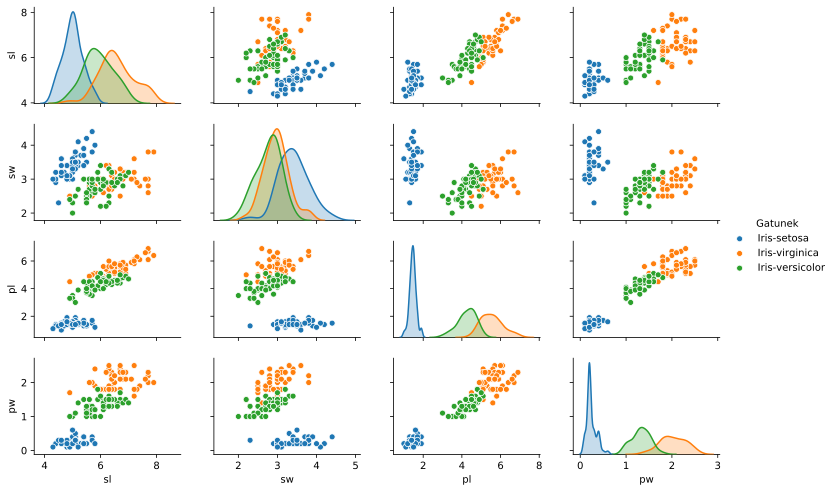

In [100]:
g = seaborn.pairplot(data_iris, hue='Gatunek', size=1.75, aspect=1.5) 

### Od regresji logistycznej dwuklasowej do wieloklasowej

* Irysy są przydzielone do trzech klas: _Iris-setosa_ (0), _Iris-versicolor_ (1), _Iris-virginica_ (2).
* Wiemy, jak stworzyć klasyfikatory typu _Iris-setosa_ vs. _Nie-Iris-setosa_ (tzw. _one-vs-all_).
* Możemy stworzyć trzy klasyfikatory $h_{\theta_1}, h_{\theta_2}, h_{\theta_3}$ (otrzymując trzy zestawy parametrów $\theta$) i wybrać klasę o najwyższym prawdopodobieństwie.

### Funkcja _softmax_

Odpowiednikiem funkcji logistycznej dla wieloklasowej regresji logistycznej jest funkcja $\mathrm{softmax}$:

$$ \textrm{softmax}(k,x_1,\dots,x_n) = \dfrac{e^{x_k}}{\sum_{i=i}^{n}e^{x_i}} $$

$$P(y=c|x;\theta_1,\ldots,\theta_k) = \textrm{softmax}(c,\theta_1^Tx,\ldots,\theta_k^Tx)$$

In [101]:
# Zapis macierzowy funkcji softmax
def softmax(X):
    return np.exp(X) / np.sum(np.exp(X))

X5 = X[:3]
print("X5 =", X5)
print("softmax =", softmax(X5))

X5 = [[1.  5.2 3.4 1.4 0.2]
 [1.  5.1 3.7 1.5 0.4]
 [1.  6.7 3.1 5.6 2.4]]
softmax = [[0.00175241 0.11686208 0.01931717 0.0026143  0.00078741]
 [0.00175241 0.10574119 0.02607546 0.00288924 0.00096175]
 [0.00175241 0.52373952 0.01431051 0.17433774 0.00710639]]


In [102]:
XN = np.matrix([2.1, 0.5, 0.8, 0.9, 3.2]).reshape(5,1)
P = softmax(XN)
print(XN)
print("Suma X =", np.sum(XN), "\n")
print(P)
print("Suma P =", np.sum(P)) 

[[2.1]
 [0.5]
 [0.8]
 [0.9]
 [3.2]]
Suma X = 7.500000000000001 

[[0.20921428]
 [0.04223963]
 [0.05701754]
 [0.06301413]
 [0.62851442]]
Suma P = 0.9999999999999999


In [103]:
def trainMaxEnt(X, Y):
    n = X.shape[1]
    thetas = []
    for c in range(Y.shape[1]):
        YBi = Y[:,c]
        theta = np.matrix(np.random.random(n)).reshape(n,1)
        thetaBest, errors = GD(h, J, dJ, theta, 
                               X, YBi, alpha=0.1, eps=10**-4)
        thetas.append(thetaBest)
    return thetas

thetas = trainMaxEnt(XTrain, YTrain);
for theta in thetas:
    print(theta, "\n")

[[ 0.18223367]
 [ 0.30855121]
 [ 1.34158506]
 [-1.94200391]
 [-0.91844209]] 

[[ 1.07969938]
 [ 0.03713041]
 [-1.06585443]
 [ 0.55937578]
 [-0.66591913]] 

[[-0.78506217]
 [-1.66364028]
 [-1.58798927]
 [ 2.30768763]
 [ 2.69329938]] 



### Funkcja decyzyjna wieloklasowej regresji logistycznej

$$ c = \mathop{\textrm{arg}\,\textrm{max}}_{i \in \{1, \ldots ,k\}} P(y=i|x;\theta_1,\ldots,\theta_k) $$

In [105]:
def classify(thetas, X, debug=False):
    regs = np.array([(X*theta).item() for theta in thetas])
    if debug:
        print("regs  =", regs)
    probs = softmax(regs)
    if debug:
        print("probs =", np.around(probs,decimals=3))
    return np.argmax(probs), probs

print("YTest =", YTest[:6])
YTestCls = YTest * np.matrix((0,1,2)).T
print("YTestCls =", YTestCls[:6], "\n")

YTest = [[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
YTestCls = [[2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [0.]] 



### Ewaluacja

Dokonajmy teraz ewaluacji przewidywań naszego algorytmu. Użyjemy w tym celu metryki **skuteczności** (ang. *accuracy*).

(Więcej o metrykach na jednym z następnych wykładów).

In [106]:
acc = 0.0
for i in range(len(YTestCls)):
    cls, probs = classify(thetas, XTest[i], i < 6)
    correctCls = int(YTestCls[i].item())
    if i < 6:
        print(correctCls, "  <=>", cls, " -- ", cls == correctCls, np.round(probs, 4).tolist())
    acc += correctCls == cls
print("\nAccuracy =", acc/len(XTest))

regs  = [-7.56256617  0.58518649  1.85156585]
probs = [0.   0.22 0.78]
2   <=> 2  --  True [0.0001, 0.2199, 0.7801]
regs  = [ 2.69369658 -1.35628758 -9.49575083]
probs = [0.983 0.017 0.   ]
0   <=> 0  --  True [0.9829, 0.0171, 0.0]
regs  = [-6.98884897  0.04764892  1.91040974]
probs = [0.    0.134 0.866]
2   <=> 2  --  True [0.0001, 0.1344, 0.8655]
regs  = [-5.52997467 -0.24463246  1.25263816]
probs = [0.001 0.183 0.816]
2   <=> 2  --  True [0.0009, 0.1827, 0.8164]
regs  = [-6.60852357  0.73519094  1.63162988]
probs = [0.   0.29 0.71]
2   <=> 2  --  True [0.0002, 0.2897, 0.7101]
regs  = [  3.41180849  -2.19205751 -10.96148911]
probs = [0.996 0.004 0.   ]
0   <=> 0  --  True [0.9963, 0.0037, 0.0]

Accuracy = 1.0
